In [2]:
import igraph as ig
import sknetwork as sn
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import adjusted_mutual_info_score as AMI
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score, accuracy_score, recall_score
from tqdm import trange, tqdm
from abcd_graph import ABCDGraph, ABCDParams

from itertools import product
import sys
import os
sys.path.append('../')
from CAS import *

import ECG.ecg_sknetwork as ecg_sn
import ecg_igraph as ecg_igraph

## Generate ABCD+o graphs using Julia

In [64]:
## utility function - we fix all the parameters in the experiments below and only vary xi
def build_ABCDo(xi, nout, num_nodes=10000):
    params = ABCDParams(
        vcount=num_nodes, 
        gamma=2.5,
        min_degree=10,
        max_degree=int(num_nodes**.5),
        beta=1.5,
        min_community_size=50,
        max_community_size=int(num_nodes**.767),
        xi=xi,
        num_outliers=nout,
    )    
    G = ABCDGraph(params)
    G.build()
    g = G.exporter.to_igraph()
    c = np.array(g.vs['ground_truth_community']) ## outliers have community 0 instead of -1

    return g, c

## Experimenting on Optimal cout cut value

- Test graph size, noise level, percent outliers


In [ ]:
n = 10000
pouts = [.01, .05, .1, .3, .5]
xis = [.4, .45, .5, .55, .6]
REP = 5

data = []
pbar = tqdm(total=len(pouts)*len(xis)*REP)
for pout, xi, rep in product(pouts, xis, range(REP)):
    g = _run_julia_abcd(n=n, nout=int(n*pout), xi=xi)
    ief_weights, beta_weights, c_weigths, p_weights, ecg_weights = ecg_igraph.ensemble_cas_edge_weights(g)
    coms = ecg_igraph.cluster_edges(g, p_weights).membership
    _, p_cout = ecg_igraph.outlier_scores(g, p_weights, coms)
    _, beta_cout = ecg_igraph.outlier_scores(g, beta_weights, coms)

    data.append([n, xi, pout, rep, "gt", np.array(g.vs["gt"])])
    data.append([n, xi, pout, rep, "clustering", coms])

    data.append([n, xi, pout, rep, "p_cout", p_cout])
    data.append([n, xi, pout, rep, "beta_cout", beta_cout])

    ief, beta, c, p, degs = CAS(g.get_adjacency_sparse(), partition2sparse(coms))
    data.append([n, xi, pout, rep, "p", get_com_score(p, coms)])
    data.append([n, xi, pout, rep, "beta", get_com_score(beta, coms)])

    pbar.update()
pbar.close()

df = pd.DataFrame(data, columns=['n', 'xi', 'pout', 'rep', 'thing', 'value'])
df.to_feather("outlier_bench.feather")

  0%|          | 0/125 [00:39<?, ?it/s]


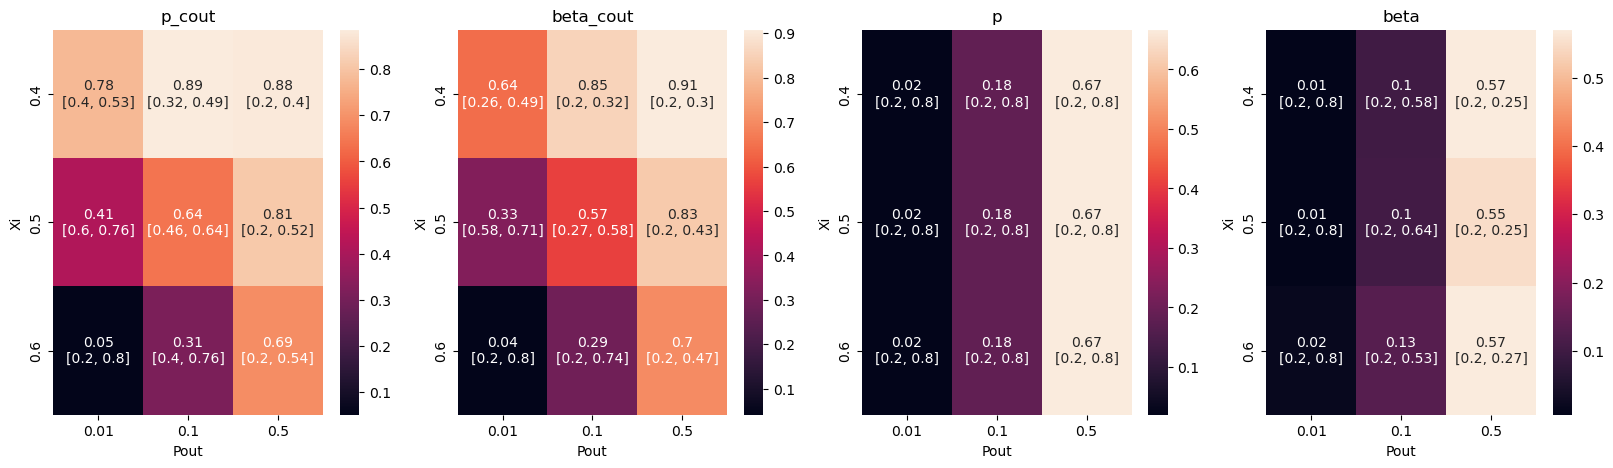

In [ ]:
rep = 1
xis = df['xi'].unique()
pouts = df['pout'].unique()
cuts = np.linspace(0.2, 0.8, 50)


def get_value(df, n, xi, pout, rep, thing):
    return df.loc[(df['n']==n) & (df['xi']==xi) & (df['pout']==pout) & (df['rep']==rep) & (df['thing']==thing)]["value"].values[0]


def get_interval(cuts, f1s, leeway=0.1):
    best = np.argmax(f1s)
    left = best
    if left != 0:
        while f1s[left-1] > f1s[best] - leeway:
            left -= 1
            if left == 0:
                break
    right = best
    if right != len(f1s) - 1:
        while f1s[right+1] > f1s[best] - leeway:
            right += 1
            if right == len(f1s)-1:
                break
    return cuts[left], cuts[right]


fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.flatten()
for i, method in enumerate(['p_cout', 'beta_cout', 'p', 'beta']):
    best_f1 = np.empty((len(xis), len(pouts)))
    left = np.empty_like(best_f1)
    right = np.empty_like(best_f1)
    for j, xi in enumerate(xis):
        for k, pout in enumerate(pouts):
            gt = get_value(df, n, xi, pout, rep, "gt") == 0
            scores = get_value(df, n, xi, pout, rep, method)
            f1s = np.empty_like(cuts)
            for p, cut in enumerate(cuts):
                f1s[p] = f1_score(gt, scores > cut)
            best_f1[j, k] = np.max(f1s)
            l, r = get_interval(cuts, f1s)
            left[j, k] = l
            right[j, k] = r
    
    frame = pd.DataFrame(best_f1, index=xis, columns=pouts)
    labels = []
    for j in range(best_f1.shape[0]):
        l = []
        for k in range(best_f1.shape[1]):
            l.append(f"{round(best_f1[j, k], 2)}\n[{round(left[j, k], 2)}, {round(right[j, k], 2)}]")
        labels.append(l)
    labels = np.asarray(labels)
    sns.heatmap(frame, ax=axs[i], annot=labels, fmt="")
    axs[i].set_title(method)
    axs[i].set_ylabel('Xi')
    axs[i].set_xlabel('Pout')

## 3x3 ROC curves

100%|██████████| 9/9 [01:50<00:00, 12.23s/it]


Text(0.5, 0.98, 'ROC Curves')

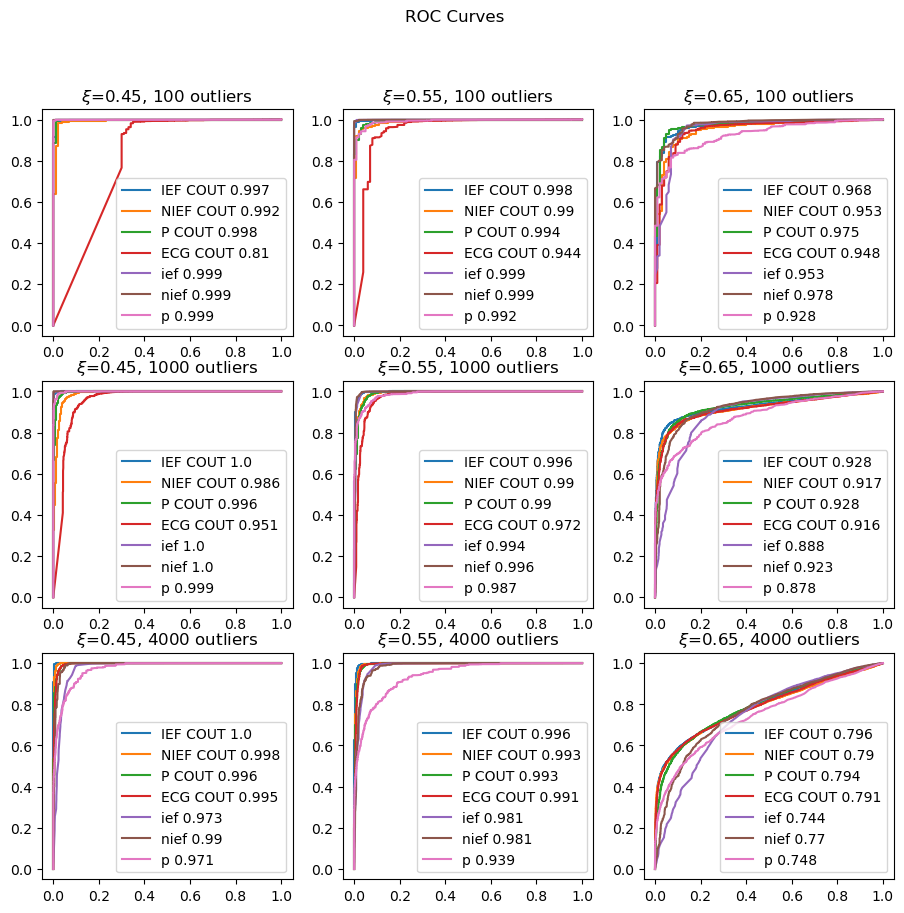

In [39]:
# Params
n = 10000
NOUTS = [100, 1000, 4000]
XIS = [.45, .55, .65]

fig, axs = plt.subplots(3, 3, figsize=(11, 10))
with tqdm(total=9) as pbar:
    for i, nout in enumerate(NOUTS):
        for j, xi in enumerate(XIS):
            g, c = build_ABCDo(xi, nout, n)
            is_not_outlier = c != -1
            com = np.array(g.community_leiden(objective_function="modularity").membership)
            #print(f"Leiden detected {np.max(com)+1} communities, gt has {np.max(c)+1}")
            options = [
                ["IEF COUT", ecg_igraph.ief_to_cluster],
                ["NIEF COUT", ecg_igraph.nief_to_cluster],
                ["P COUT", ecg_igraph.p_to_cluster],
                ["ECG COUT", ecg_igraph.ecg_to_cluster]
            ]
            for name, cas in options:
                g.es["w"] = ecg_igraph.ensemble_edge_weights(g, cas=cas)
                adj = g.get_adjacency_sparse(attribute="w")
                scores = ecg_igraph.get_scores(adj.indptr, adj.indices, adj.data, com, score="cout")
                fpr, tpr, thresholds = roc_curve(is_not_outlier, scores, pos_label=1)
                axs[i, j].plot(fpr, tpr, label=name+" "+str(round(AUC(is_not_outlier, scores),3)))

            options = ["ief", "nief", "p"]
            for name in options:
                adj = g.get_adjacency_sparse()
                scores = ecg_igraph.get_scores(adj.indptr, adj.indices, adj.data, com, score=name)
                #print(any(np.isnan(scores)))
                #print(name, f"min score: {np.min(scores)}, max: {np.max(scores)}")
                fpr, tpr, thresholds = roc_curve(is_not_outlier, scores, pos_label=1)
                axs[i, j].plot(fpr, tpr, label=name+" "+str(round(AUC(is_not_outlier, scores),3)))

            axs[i, j].set_title(r"$\xi$" + f"={xi}, {nout} outliers")
            axs[i, j].legend()
            pbar.update()

plt.suptitle("ROC Curves")

100%|██████████| 108/108 [06:50<00:00,  3.80s/it]


Text(0.5, 1.0, 'Average AUC score for predicing is_not_outlier with P COUT')

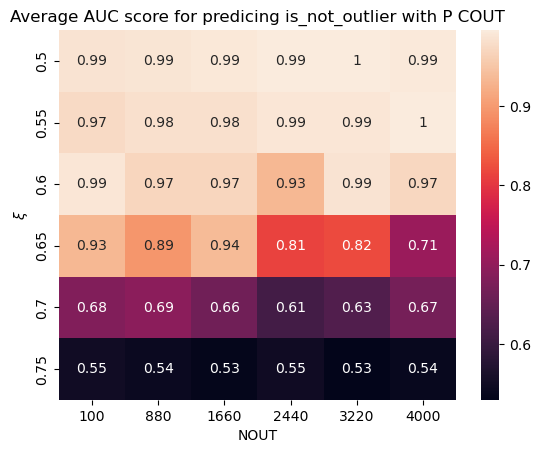

In [65]:
## For one pruning method, make a heatmap of average AUC score
REP = 3
n = 10000
XIS = np.round(np.linspace(0.5, 0.75, 6), 3)
NOUTS = np.linspace(100, 4000, 6, dtype="int64")

def score_func(g, com):
    g.es["w"] = ecg_igraph.ensemble_edge_weights(g, cas=ecg_igraph.p_to_cluster)
    adj = g.get_adjacency_sparse(attribute="w")
    scores = ecg_igraph.get_scores(adj.indptr, adj.indices, adj.data, com, score="cout")
    return scores

aucs = np.empty((len(XIS), len(NOUTS), REP))
with tqdm(total=len(XIS)*len(NOUTS)*REP) as pbar:
    for i, xi in enumerate(XIS):
        for j, nout in enumerate(NOUTS):
            for k in range(REP):
                g, c = build_ABCDo(xi, nout, n)
                is_not_outlier = c != -1
                com = np.array(g.community_leiden(objective_function="modularity").membership)
                scores = score_func(g, com)
                aucs[i, j, k] = AUC(is_not_outlier, scores)

                pbar.update()

sns.heatmap(np.mean(aucs, axis=2), yticklabels=XIS, xticklabels=NOUTS, annot=True)
plt.ylabel(r"$\xi$")
plt.xlabel("NOUT")
plt.title("Average AUC score for predicing is_not_outlier with P COUT")

100%|██████████| 108/108 [06:00<00:00,  3.34s/it]


Text(0.5, 1.0, 'Average AUC score for predicing is_not_outlier with IEF COUT')

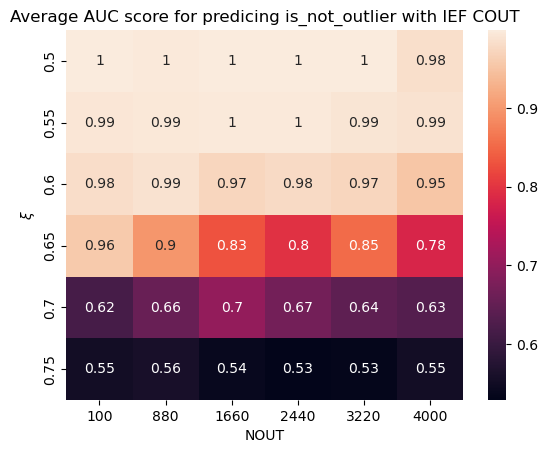

In [66]:
## For one pruning method, make a heatmap of average AUC score
REP = 3
n = 10000
XIS = np.round(np.linspace(0.5, 0.75, 6), 3)
NOUTS = np.linspace(100, 4000, 6, dtype="int64")

def score_func(g, com):
    g.es["w"] = ecg_igraph.ensemble_edge_weights(g, cas=ecg_igraph.ief_to_cluster)
    adj = g.get_adjacency_sparse(attribute="w")
    scores = ecg_igraph.get_scores(adj.indptr, adj.indices, adj.data, com, score="cout")
    return scores

aucs = np.empty((len(XIS), len(NOUTS), REP))
with tqdm(total=len(XIS)*len(NOUTS)*REP) as pbar:
    for i, xi in enumerate(XIS):
        for j, nout in enumerate(NOUTS):
            for k in range(REP):
                g, c = build_ABCDo(xi, nout, n)
                is_not_outlier = c != -1
                com = np.array(g.community_leiden(objective_function="modularity").membership)
                scores = score_func(g, com)
                aucs[i, j, k] = AUC(is_not_outlier, scores)

                pbar.update()

sns.heatmap(np.mean(aucs, axis=2), yticklabels=XIS, xticklabels=NOUTS, annot=True)
plt.ylabel(r"$\xi$")
plt.xlabel("NOUT")
plt.title("Average AUC score for predicing is_not_outlier with IEF COUT")

100%|██████████| 108/108 [00:52<00:00,  2.05it/s]


Text(0.5, 1.0, 'Average AUC score for predicing is_not_outlier with IEF')

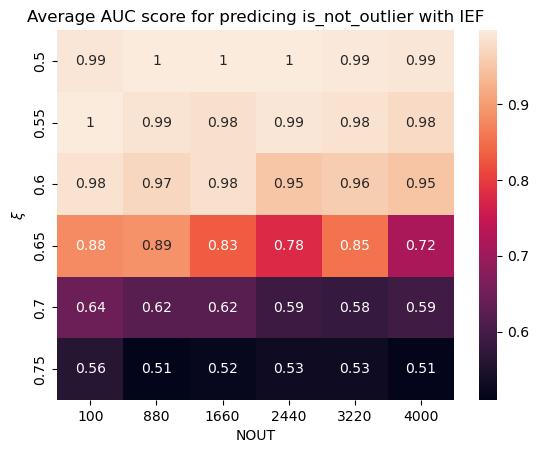

In [67]:
## For one pruning method, make a heatmap of average AUC score
REP = 3
n = 10000
XIS = np.round(np.linspace(0.5, 0.75, 6), 3)
NOUTS = np.linspace(100, 4000, 6, dtype="int64")

def score_func(g, com):
    adj = g.get_adjacency_sparse()
    scores = ecg_igraph.get_scores(adj.indptr, adj.indices, adj.data, com, score="ief")
    return scores

aucs = np.empty((len(XIS), len(NOUTS), REP))
with tqdm(total=len(XIS)*len(NOUTS)*REP) as pbar:
    for i, xi in enumerate(XIS):
        for j, nout in enumerate(NOUTS):
            for k in range(REP):
                g, c = build_ABCDo(xi, nout, n)
                is_not_outlier = c != -1
                com = np.array(g.community_leiden(objective_function="modularity").membership)
                scores = score_func(g, com)
                aucs[i, j, k] = AUC(is_not_outlier, scores)

                pbar.update()

sns.heatmap(np.mean(aucs, axis=2), yticklabels=XIS, xticklabels=NOUTS, annot=True)
plt.ylabel(r"$\xi$")
plt.xlabel("NOUT")
plt.title("Average AUC score for predicing is_not_outlier with IEF")

100%|██████████| 108/108 [00:53<00:00,  2.02it/s]


Text(0.5, 1.0, 'Average AUC score for predicing is_not_outlier with NIEF')

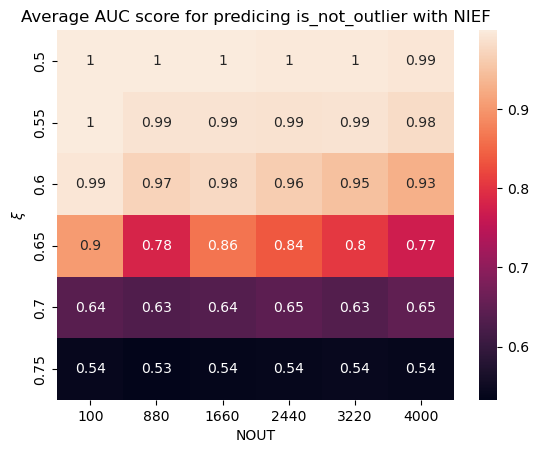

In [68]:
## For one pruning method, make a heatmap of average AUC score
REP = 3
n = 10000
XIS = np.round(np.linspace(0.5, 0.75, 6), 3)
NOUTS = np.linspace(100, 4000, 6, dtype="int64")

def score_func(g, com):
    adj = g.get_adjacency_sparse()
    scores = ecg_igraph.get_scores(adj.indptr, adj.indices, adj.data, com, score="nief")
    return scores

aucs = np.empty((len(XIS), len(NOUTS), REP))
with tqdm(total=len(XIS)*len(NOUTS)*REP) as pbar:
    for i, xi in enumerate(XIS):
        for j, nout in enumerate(NOUTS):
            for k in range(REP):
                g, c = build_ABCDo(xi, nout, n)
                is_not_outlier = c != -1
                com = np.array(g.community_leiden(objective_function="modularity").membership)
                scores = score_func(g, com)
                aucs[i, j, k] = AUC(is_not_outlier, scores)

                pbar.update()

sns.heatmap(np.mean(aucs, axis=2), yticklabels=XIS, xticklabels=NOUTS, annot=True)
plt.ylabel(r"$\xi$")
plt.xlabel("NOUT")
plt.title("Average AUC score for predicing is_not_outlier with NIEF")

100%|██████████| 108/108 [00:53<00:00,  2.03it/s]


Text(0.5, 1.0, 'Average AUC score for predicing is_not_outlier with P')

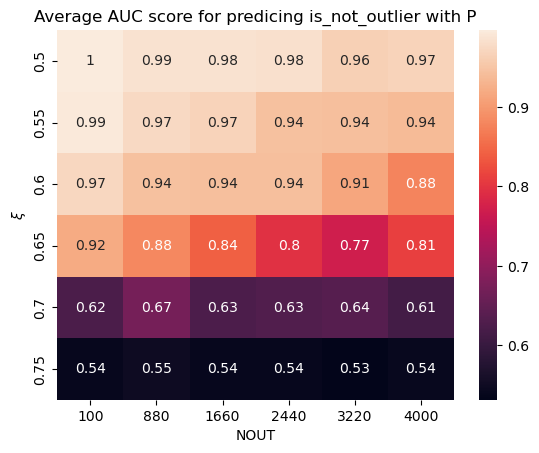

In [69]:
## For one pruning method, make a heatmap of average AUC score
REP = 3
n = 10000
XIS = np.round(np.linspace(0.5, 0.75, 6), 3)
NOUTS = np.linspace(100, 4000, 6, dtype="int64")

def score_func(g, com):
    adj = g.get_adjacency_sparse()
    scores = ecg_igraph.get_scores(adj.indptr, adj.indices, adj.data, com, score="p")
    return scores

aucs = np.empty((len(XIS), len(NOUTS), REP))
with tqdm(total=len(XIS)*len(NOUTS)*REP) as pbar:
    for i, xi in enumerate(XIS):
        for j, nout in enumerate(NOUTS):
            for k in range(REP):
                g, c = build_ABCDo(xi, nout, n)
                is_not_outlier = c != -1
                com = np.array(g.community_leiden(objective_function="modularity").membership)
                scores = score_func(g, com)
                aucs[i, j, k] = AUC(is_not_outlier, scores)

                pbar.update()

sns.heatmap(np.mean(aucs, axis=2), yticklabels=XIS, xticklabels=NOUTS, annot=True)
plt.ylabel(r"$\xi$")
plt.xlabel("NOUT")
plt.title("Average AUC score for predicing is_not_outlier with P")

## If we prune (and recalculate) up to a moderate threshhold does it prune the whole graph?

In [28]:
# Params
REP = 10
n = 10000
NOUTS = [100, 1000, 4000]
XIS = [.45, .55, .65]
cuts = np.linspace(0.1, 0.8, 51)

# Initialize results storage
pcout_pruned_rec = np.empty((REP, len(XIS), len(NOUTS), len(cuts), n), dtype="bool")
niefcout_pruned_rec = np.empty_like(pcout_pruned_rec)
iefcout_pruned_rec = np.empty_like(pcout_pruned_rec)
ecgcout_pruned_rec = np.empty_like(pcout_pruned_rec)

p_pruned_rec = np.empty_like(pcout_pruned_rec)
nief_pruned_rec = np.empty_like(pcout_pruned_rec)
ief_pruned_rec = np.empty_like(pcout_pruned_rec)

gts = np.empty((REP, len(XIS), len(NOUTS), n), dtype="int32")
coms = np.empty((REP, len(XIS), len(NOUTS), n), dtype="int32")

# Compute
with tqdm(total=REP*len(XIS)*len(NOUTS)*len(cuts)) as pbar:
    for rep in range(REP):
        for i, xi in enumerate(XIS):
            for j, nout in enumerate(NOUTS):

                g, gt = build_ABCDo(xi, nout, num_nodes=n)
                gts[rep, i, j, :] = gt

                ief = ecg_igraph.ensemble_edge_weights(g, cas=ecg_igraph.ief_to_cluster)
                nief = ecg_igraph.ensemble_edge_weights(g, cas=ecg_igraph.nief_to_cluster)
                p = ecg_igraph.ensemble_edge_weights(g, cas=ecg_igraph.p_to_cluster)
                ecg = ecg_igraph.ensemble_edge_weights(g, cas=ecg_igraph.ecg_to_cluster)

                com = np.array(g.community_leiden(objective_function="modularity").membership)
                coms[rep, i, j, :] = com

                for k, c in enumerate(cuts):
                    iefcout_pruned_rec[rep, i, j, k, :] = ecg_igraph.prune(g, com, c, score="cout", edge_weights=ief)
                    niefcout_pruned_rec[rep, i, j, k, :] = ecg_igraph.prune(g, com, c, score="cout", edge_weights=nief)
                    pcout_pruned_rec[rep, i, j, k, :] = ecg_igraph.prune(g, com, c, score="cout", edge_weights=p)
                    ecgcout_pruned_rec[rep, i, j, k, :] = ecg_igraph.prune(g, com, c, score="cout", edge_weights=ecg)

                    #iefcout_pruned_one[rep, i, j, k, :] = ecg_igraph.prune(g, coms, c, score="cout", max_per_round=n, recursive=False, edge_weights=ief)
                    #niefcout_pruned_one[rep, i, j, k, :] = ecg_igraph.prune(g, coms, c, score="cout", max_per_round=n, recursive=False, edge_weights=nief)
                    #pcout_pruned_one[rep, i, j, k, :] = ecg_igraph.prune(g, coms, c, score="cout", max_per_round=n, recursive=False, edge_weights=p)
                    #ecgcout_pruned_one[rep, i, j, k, :] = ecg_igraph.prune(g, coms, c, score="cout", max_per_round=n, recursive=False, edge_weights=ecg)

                    ief_pruned_rec[rep, i, j, k, :] = ecg_igraph.prune(g, com, c, score="ief")
                    nief_pruned_rec[rep, i, j, k, :] = ecg_igraph.prune(g, com, c, score="nief")
                    p_pruned_rec[rep, i, j, k, :] = ecg_igraph.prune(g, com, c, score="p")

                    #ief_pruned_one[rep, i, j, k, :] = ecg_igraph.prune(g, coms, c, score="ief", max_per_round=n, recursive=False)
                    #nief_pruned_one[rep, i, j, k, :] = ecg_igraph.prune(g, coms, c, score="nief", max_per_round=n, recursive=False)
                    #p_pruned_one[rep, i, j, k, :] = ecg_igraph.prune(g, coms, c, score="p", max_per_round=n, recursive=False)
        
                    pbar.update()


 42%|████▏     | 4810/11475 [56:52<55:16,  2.01it/s]  Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f54878d4bd0>>
Traceback (most recent call last):
  File "/home/rdewolfe/miniforge3/envs/cas/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
 42%|████▏     | 4829/11475 [57:03<1:11:31,  1.55it/s]

In [14]:
import pickle
data = {
    "pcout_pruned_rec": pcout_pruned_rec,
    "niefcout_pruned_rec": niefcout_pruned_rec,
    "iefcout_pruned_rec": iefcout_pruned_rec,
    "ecgcout_pruned_rec": ecgcout_pruned_rec,
    "p_pruned_rec": p_pruned_rec,
    "nief_pruned_rec": nief_pruned_rec,
    "ief_pruned_rec": ief_pruned_rec,
    "gts": gts,
    "coms": coms
}
with open("outlier_test.pkl", "wb") as f:
    pickle.dump(data, f)

In [7]:
import pickle
with open("outlier_test.pkl", "rb") as f:
    data = pickle.load(f)

pcout_pruned_rec = data["pcout_pruned_rec"]
niefcout_pruned_rec = data['niefcout_pruned_rec']
iefcout_pruned_rec = data['iefcout_pruned_rec']
ecgcout_pruned_rec = data['ecgcout_pruned_rec']
p_pruned_rec = data['p_pruned_rec']
nief_pruned_rec = data['nief_pruned_rec']
ief_pruned_rec = data['ief_pruned_rec']
gts = data['gts']
coms = data['coms']

REP = 5
n = 10000
NOUTS = [100, 1000, 4000]
XIS = [.5, .6, .7]
cuts = np.linspace(0.2, 0.8, 61)

Text(0.5, 0.98, 'Average F1 Score vs. Threshold over 5 ABCDo graphs')

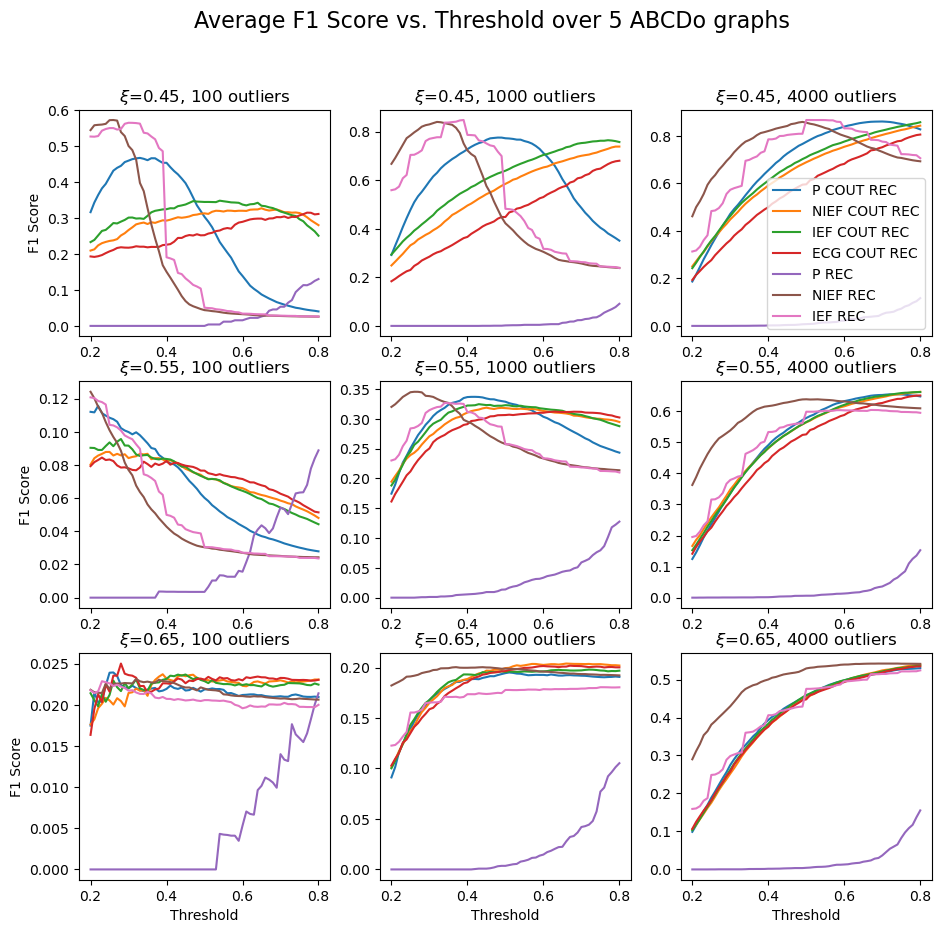

In [15]:
def make_scores(score_function, pruned, gt):
    results = np.empty((pruned.shape[0], pruned.shape[1]))
    for rep in range(pruned.shape[0]):
        is_outlier = gt[rep, :] == -1
        for i in range(pruned.shape[1]):
            results[rep, i] = score_function(is_outlier, pruned[rep, i, :])
    return results


options = [
    [pcout_pruned_rec, "P COUT REC"],
    [niefcout_pruned_rec, "NIEF COUT REC"],
    [iefcout_pruned_rec, "IEF COUT REC"],
    [ecgcout_pruned_rec, "ECG COUT REC"],
    #[pcout_pruned_one, "P COUT"],
    #[niefcout_pruned_one, "NIEF COUT"],
    #[iefcout_pruned_one, "IEF COUT"],
    #[ecgcout_pruned_one, "ECG COUT"],
    [p_pruned_rec, "P REC"],
    [nief_pruned_rec, "NIEF REC"],
    [ief_pruned_rec, "IEF REC"],
    #[p_pruned_one, "P"],
    #[nief_pruned_one, "NIEF"],
    #[ief_pruned_one, "IEF"],
]

fig, axs = plt.subplots(3, 3, figsize=(11, 10))
for i, xi in enumerate(XIS):
    for j, nout in enumerate(NOUTS):
        for pruned, name in options:
            f1 = np.mean(make_scores(f1_score, pruned[:, i, j, :, :], gts[:, i, j, :]), axis=0)
            axs[i, j].plot(cuts, f1, label=name)
            axs[i, j].set_title(r"$\xi$" + f"={xi}, {nout} outliers")

axs[0, 0].set_ylabel("F1 Score")
axs[1, 0].set_ylabel("F1 Score")
axs[2, 0].set_ylabel("F1 Score")
axs[2, 0].set_xlabel("Threshold")
axs[2, 1].set_xlabel("Threshold")
axs[2, 2].set_xlabel(f"Threshold")
axs[0, 2].legend()
plt.suptitle(f"Average F1 Score vs. Threshold over {REP} ABCDo graphs", fontsize=16)

Text(0.5, 0.98, 'Average AMI vs. Threshold over 5 ABCDo graphs')

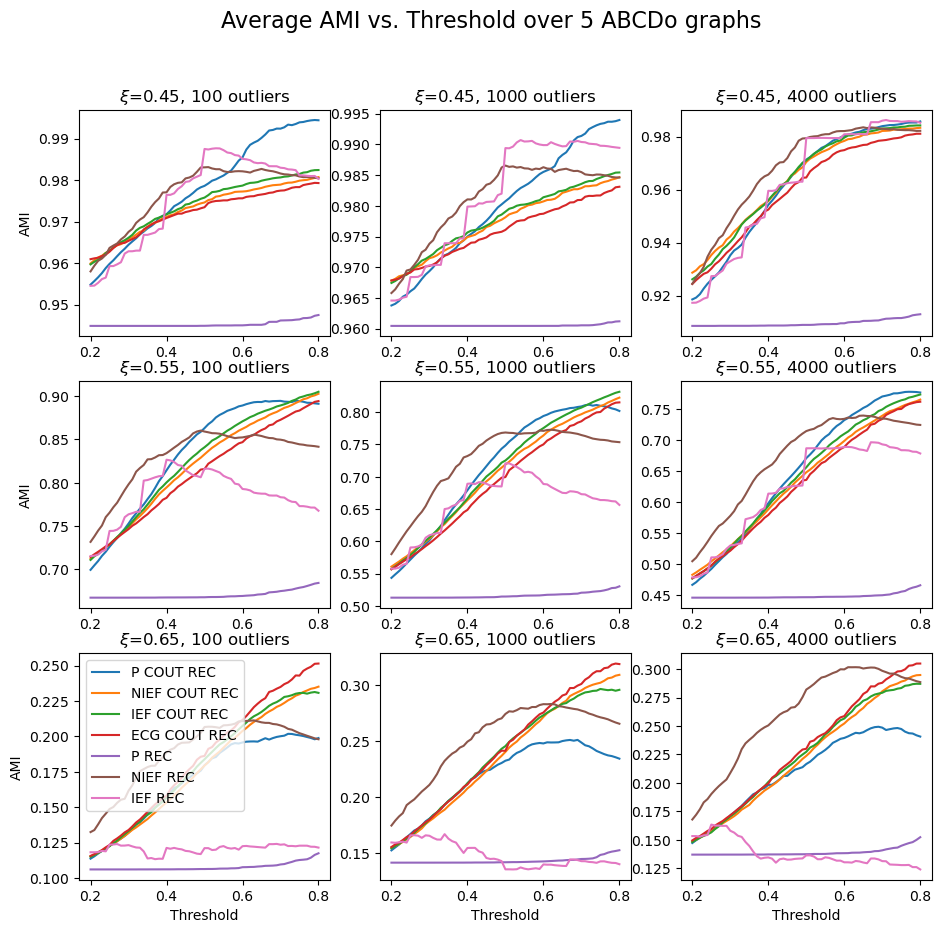

In [16]:
def make_ami_scores(pruned, gt, coms):
    results = np.empty((pruned.shape[0], pruned.shape[1]))
    for rep in range(pruned.shape[0]):
        for i in range(pruned.shape[1]):
            is_outlier_or_pruned = np.bitwise_or(gt[rep, :] == -1, pruned[rep, i, :])
            results[rep, i] = AMI(gt[rep, :][~is_outlier_or_pruned], coms[rep, :][~is_outlier_or_pruned])
    return results


options = [
    [pcout_pruned_rec, "P COUT REC"],
    [niefcout_pruned_rec, "NIEF COUT REC"],
    [iefcout_pruned_rec, "IEF COUT REC"],
    [ecgcout_pruned_rec, "ECG COUT REC"],
    #[pcout_pruned_one, "P COUT"],
    #[niefcout_pruned_one, "NIEF COUT"],
    #[iefcout_pruned_one, "IEF COUT"],
    #[ecgcout_pruned_one, "ECG COUT"],
    [p_pruned_rec, "P REC"],
    [nief_pruned_rec, "NIEF REC"],
    [ief_pruned_rec, "IEF REC"],
    #[p_pruned_one, "P"],
    #[nief_pruned_one, "NIEF"],
    #[ief_pruned_one, "IEF"],
]

fig, axs = plt.subplots(3, 3, figsize=(11, 10))
for i, xi in enumerate(XIS):
    for j, nout in enumerate(NOUTS):
        for pruned, name in options:
            f1 = np.mean(make_ami_scores(pruned[:, i, j, :, :], gts[:, i, j, :], coms[:, i, j, :]), axis=0)
            axs[i, j].plot(cuts, f1, label=name)
            axs[i, j].set_title(r"$\xi$" + f"={xi}, {nout} outliers")

axs[0, 0].set_ylabel("AMI")
axs[1, 0].set_ylabel("AMI")
axs[2, 0].set_ylabel("AMI")
axs[2, 0].set_xlabel("Threshold")
axs[2, 1].set_xlabel("Threshold")
axs[2, 2].set_xlabel(f"Threshold")
axs[2, 0].legend()
plt.suptitle(f"Average AMI vs. Threshold over {REP} ABCDo graphs", fontsize=16)

Text(0.5, 0.98, 'Average Recall vs. Threshold over 5 ABCDo graphs')

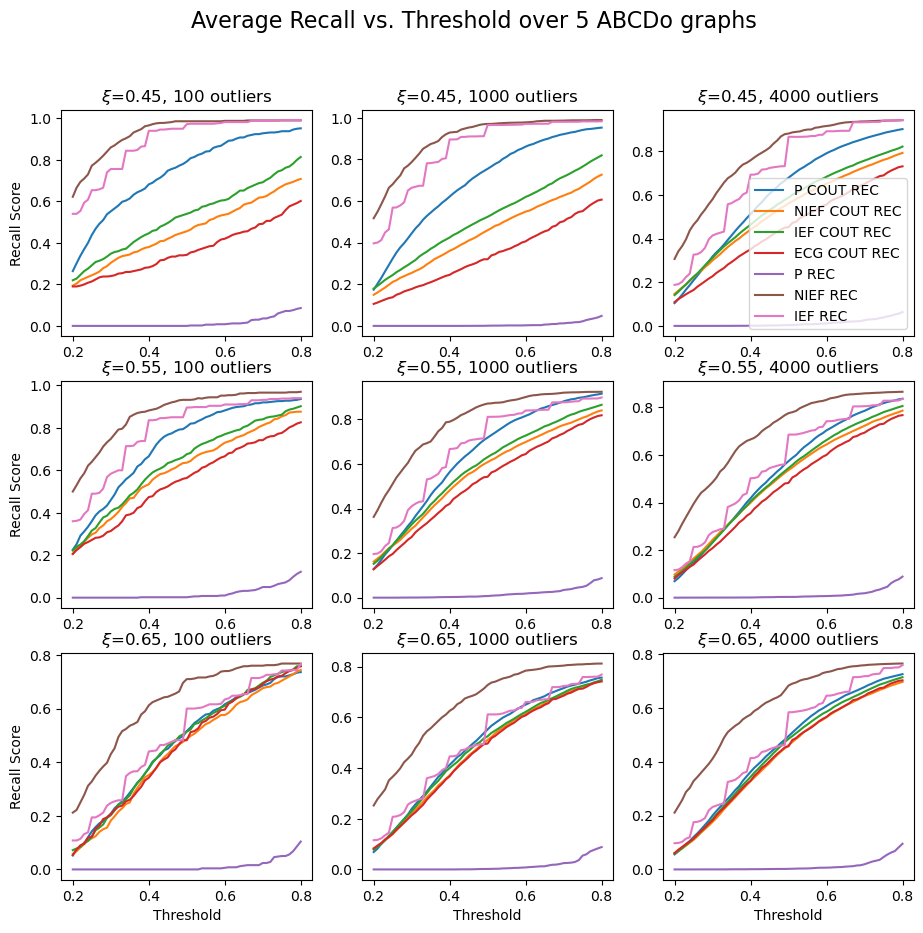

In [17]:
def make_scores(score_function, pruned, gt):
    results = np.empty((pruned.shape[0], pruned.shape[1]))
    for rep in range(pruned.shape[0]):
        is_outlier = gt[rep, :] == -1
        for i in range(pruned.shape[1]):
            results[rep, i] = score_function(is_outlier, pruned[rep, i, :])
    return results


options = [
    [pcout_pruned_rec, "P COUT REC"],
    [niefcout_pruned_rec, "NIEF COUT REC"],
    [iefcout_pruned_rec, "IEF COUT REC"],
    [ecgcout_pruned_rec, "ECG COUT REC"],
    #[pcout_pruned_one, "P COUT"],
    #[niefcout_pruned_one, "NIEF COUT"],
    #[iefcout_pruned_one, "IEF COUT"],
    #[ecgcout_pruned_one, "ECG COUT"],
    [p_pruned_rec, "P REC"],
    [nief_pruned_rec, "NIEF REC"],
    [ief_pruned_rec, "IEF REC"],
    #[p_pruned_one, "P"],
    #[nief_pruned_one, "NIEF"],
    #[ief_pruned_one, "IEF"],
]

fig, axs = plt.subplots(3, 3, figsize=(11, 10))
for i, xi in enumerate(XIS):
    for j, nout in enumerate(NOUTS):
        for pruned, name in options:
            f1 = np.mean(make_scores(recall_score, pruned[:, i, j, :, :], gts[:, i, j, :]), axis=0)
            axs[i, j].plot(cuts, f1, label=name)
            axs[i, j].set_title(r"$\xi$" + f"={xi}, {nout} outliers")

axs[0, 0].set_ylabel("Recall Score")
axs[1, 0].set_ylabel("Recall Score")
axs[2, 0].set_ylabel("Recall Score")
axs[2, 0].set_xlabel("Threshold")
axs[2, 1].set_xlabel("Threshold")
axs[2, 2].set_xlabel(f"Threshold")
axs[0, 2].legend()
plt.suptitle(f"Average Recall vs. Threshold over {REP} ABCDo graphs", fontsize=16)

Text(0.5, 0.98, 'Average Accuracy vs. Threshold over 5 ABCDo graphs')

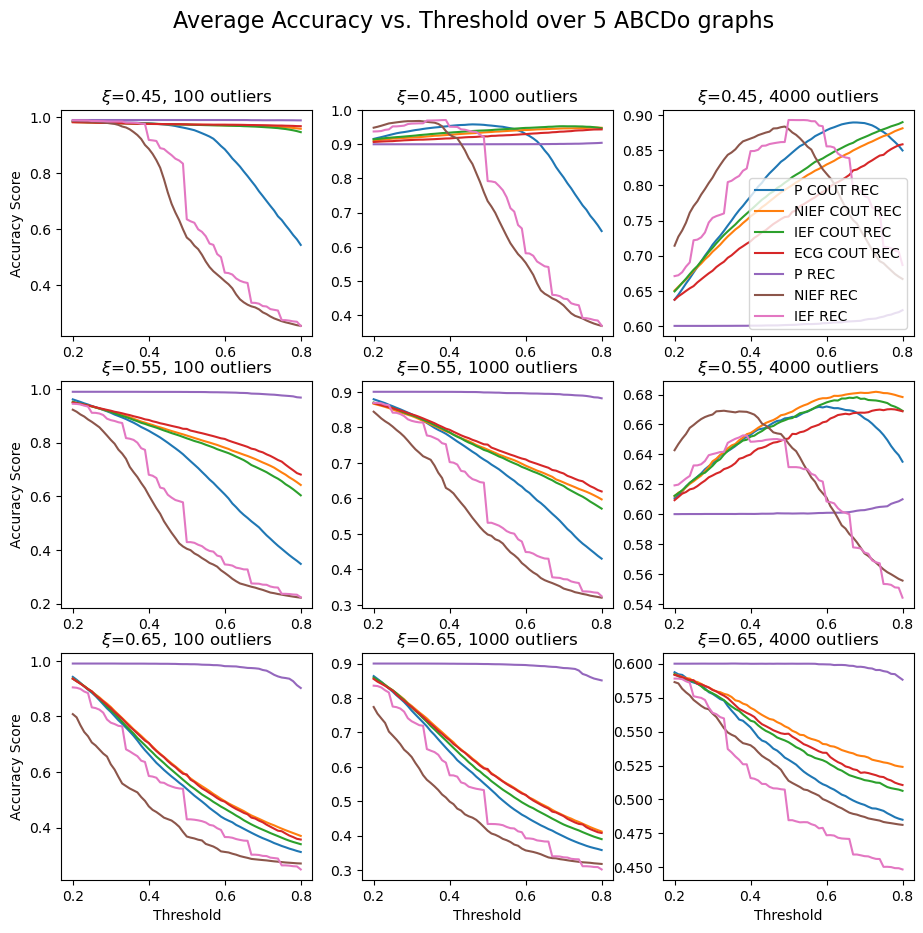

In [18]:
def make_scores(score_function, pruned, gt):
    results = np.empty((pruned.shape[0], pruned.shape[1]))
    for rep in range(pruned.shape[0]):
        is_outlier = gt[rep, :] == -1
        for i in range(pruned.shape[1]):
            results[rep, i] = score_function(is_outlier, pruned[rep, i, :])
    return results


options = [
    [pcout_pruned_rec, "P COUT REC"],
    [niefcout_pruned_rec, "NIEF COUT REC"],
    [iefcout_pruned_rec, "IEF COUT REC"],
    [ecgcout_pruned_rec, "ECG COUT REC"],
    #[pcout_pruned_one, "P COUT"],
    #[niefcout_pruned_one, "NIEF COUT"],
    #[iefcout_pruned_one, "IEF COUT"],
    #[ecgcout_pruned_one, "ECG COUT"],
    [p_pruned_rec, "P REC"],
    [nief_pruned_rec, "NIEF REC"],
    [ief_pruned_rec, "IEF REC"],
    #[p_pruned_one, "P"],
    #[nief_pruned_one, "NIEF"],
    #[ief_pruned_one, "IEF"],
]

fig, axs = plt.subplots(3, 3, figsize=(11, 10))
for i, xi in enumerate(XIS):
    for j, nout in enumerate(NOUTS):
        for pruned, name in options:
            f1 = np.mean(make_scores(accuracy_score, pruned[:, i, j, :, :], gts[:, i, j, :]), axis=0)
            axs[i, j].plot(cuts, f1, label=name)
            axs[i, j].set_title(r"$\xi$" + f"={xi}, {nout} outliers")

axs[0, 0].set_ylabel("Accuracy Score")
axs[1, 0].set_ylabel("Accuracy Score")
axs[2, 0].set_ylabel("Accuracy Score")
axs[2, 0].set_xlabel("Threshold")
axs[2, 1].set_xlabel("Threshold")
axs[2, 2].set_xlabel(f"Threshold")
axs[0, 2].legend()
plt.suptitle(f"Average Accuracy vs. Threshold over {REP} ABCDo graphs", fontsize=16)

Text(0.5, 0.98, 'Average # outliers vs. Threshold over 5 ABCDo graphs')

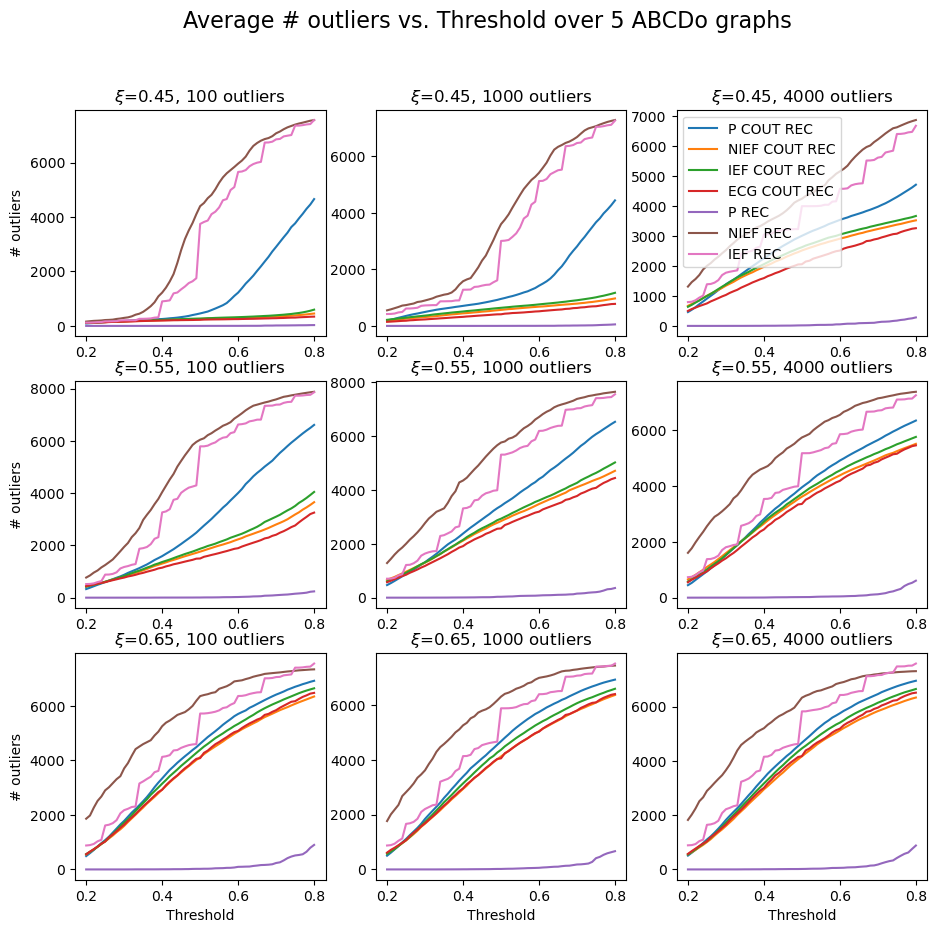

In [19]:

options = [
    [pcout_pruned_rec, "P COUT REC"],
    [niefcout_pruned_rec, "NIEF COUT REC"],
    [iefcout_pruned_rec, "IEF COUT REC"],
    [ecgcout_pruned_rec, "ECG COUT REC"],
    #[pcout_pruned_one, "P COUT"],
    #[niefcout_pruned_one, "NIEF COUT"],
    #[iefcout_pruned_one, "IEF COUT"],
    #[ecgcout_pruned_one, "ECG COUT"],
    [p_pruned_rec, "P REC"],
    [nief_pruned_rec, "NIEF REC"],
    [ief_pruned_rec, "IEF REC"],
    #[p_pruned_one, "P"],
    #[nief_pruned_one, "NIEF"],
    #[ief_pruned_one, "IEF"],
]

fig, axs = plt.subplots(3, 3, figsize=(11, 10))
for i, xi in enumerate(XIS):
    for j, nout in enumerate(NOUTS):
        for pruned, name in options:
            f1 = np.mean(np.sum(pruned[:, i, j, :, :], axis=-1), axis=0)
            axs[i, j].plot(cuts, f1, label=name)
            axs[i, j].set_title(r"$\xi$" + f"={xi}, {nout} outliers")

axs[0, 0].set_ylabel("# outliers")
axs[1, 0].set_ylabel("# outliers")
axs[2, 0].set_ylabel("# outliers")
axs[2, 0].set_xlabel("Threshold")
axs[2, 1].set_xlabel("Threshold")
axs[2, 2].set_xlabel(f"Threshold")
axs[0, 2].legend()
plt.suptitle(f"Average # outliers vs. Threshold over {REP} ABCDo graphs", fontsize=16)

## Consider Testing
I think it's fine to only consider the simplest pruning strategy.
Either (a) one shot prune below threshhold, or (b) multiround prune while below threshhold
(a) takes a threshhold parameter
(b) takes a threshhold parameter, and a max prunes per round parameter (which can perhaps be automatically guess assuming we want something like 10 rounds).

1. ABCDo range of usable F1 scores for predicting outliers. Test each score with each pruning method.
2. Real graphs (SNAP), probably considering noise as not in a strong commuity (given by strongtest community labels available)

A test, how well it could do can be measured by the max F1 score.
Maybe we consider viable parameter options anything within 10% of the max F1 score.

Hopefully at least one pair of score/method shows enough promise with some parameters to be considered usable.


Try on real graphs from SNAP instead of a big and costly simulation. (SNAP is too big for this laptop. Consider running with more RAM or using sn version)

# Real Graphs

100%|██████████| 61/61 [00:00<00:00, 129.57it/s]


CPU times: user 2.5 s, sys: 2 μs, total: 2.5 s
Wall time: 2.5 s


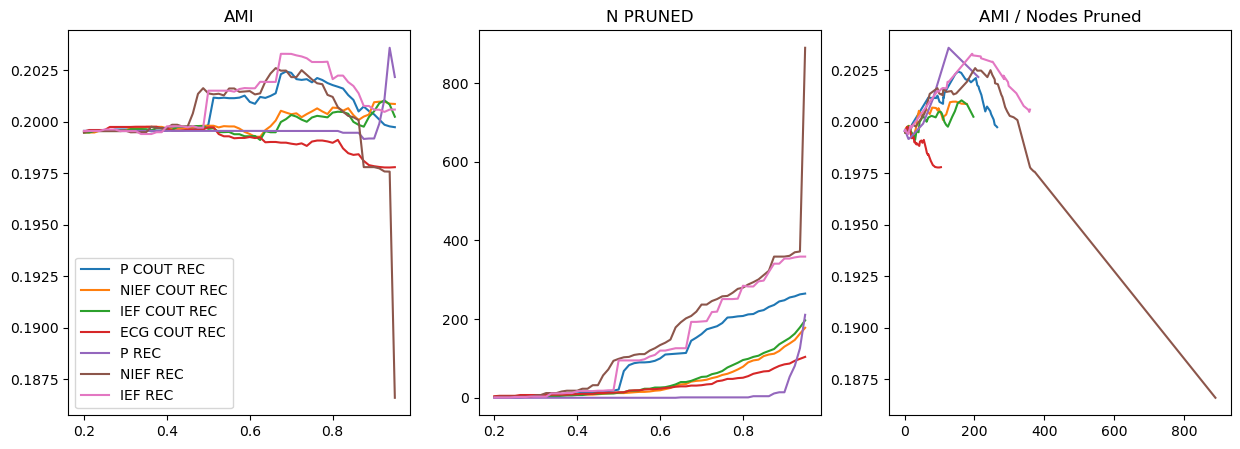

In [14]:
%%time
g = ig.Graph.Read_GML("real_data/citeseer.gml")
g = g.as_undirected()
vals = np.unique(g.vs["gt"])
id_map = {j:i for i,j in enumerate(vals)}
gt = np.array([id_map[i] for i in g.vs["gt"]])
g = g.get_adjacency_sparse()


p = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.p_to_cluster)
coms = ecg_sn.cluster_edges(g, p)
ecg = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.ecg_to_cluster)
ecg_coms = ecg_sn.cluster_edges(g, ecg)


ief = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.ief_to_cluster)
nief = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.nief_to_cluster)
p = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.p_to_cluster)
ecg = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.ecg_to_cluster)


cuts = np.linspace(0.2, 0.95, 61)
pcout_pruned_rec = []
niefcout_pruned_rec = []
iefcout_pruned_rec = []
ecgcout_pruned_rec = []

p_pruned_rec = []
nief_pruned_rec = []
ief_pruned_rec = []

for c in tqdm(cuts):
    iefcout_pruned_rec.append(ecg_sn.prune(g, coms, c, score="cout", edge_weights=ief))
    niefcout_pruned_rec.append(ecg_sn.prune(g, coms, c, score="cout", edge_weights=nief))
    pcout_pruned_rec.append(ecg_sn.prune(g, coms, c, score="cout", edge_weights=p))
    ecgcout_pruned_rec.append(ecg_sn.prune(g, coms, c, score="cout", edge_weights=ecg))

    ief_pruned_rec.append(ecg_sn.prune(g, coms, c, score="ief", max_per_round=100))
    nief_pruned_rec.append(ecg_sn.prune(g, coms, c, score="nief", max_per_round=100))
    p_pruned_rec.append(ecg_sn.prune(g, coms, c, score="p", max_per_round=100))

# plotting
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
options = [
    [pcout_pruned_rec, "P COUT REC"],
    [niefcout_pruned_rec, "NIEF COUT REC"],
    [iefcout_pruned_rec, "IEF COUT REC"],
    [ecgcout_pruned_rec, "ECG COUT REC"],
    [p_pruned_rec, "P REC"],
    [nief_pruned_rec, "NIEF REC"],
    [ief_pruned_rec, "IEF REC"],
]
for pruned, name in options:
    axs[0].plot(cuts, [AMI(gt[~p], coms[~p]) for p in pruned], label=name)
    axs[1].plot(cuts, [np.sum(p) for p in pruned], label=name)
    axs[2].plot([np.sum(p) for p in pruned], [AMI(gt[~p], coms[~p]) for p in pruned], label=name)
    
axs[0].set_title("AMI")
axs[1].set_title("N PRUNED")
axs[2].set_title("AMI / Nodes Pruned")
axs[0].legend()

100%|██████████| 61/61 [00:20<00:00,  2.91it/s]


CPU times: user 38.8 s, sys: 16 ms, total: 38.8 s
Wall time: 38.8 s


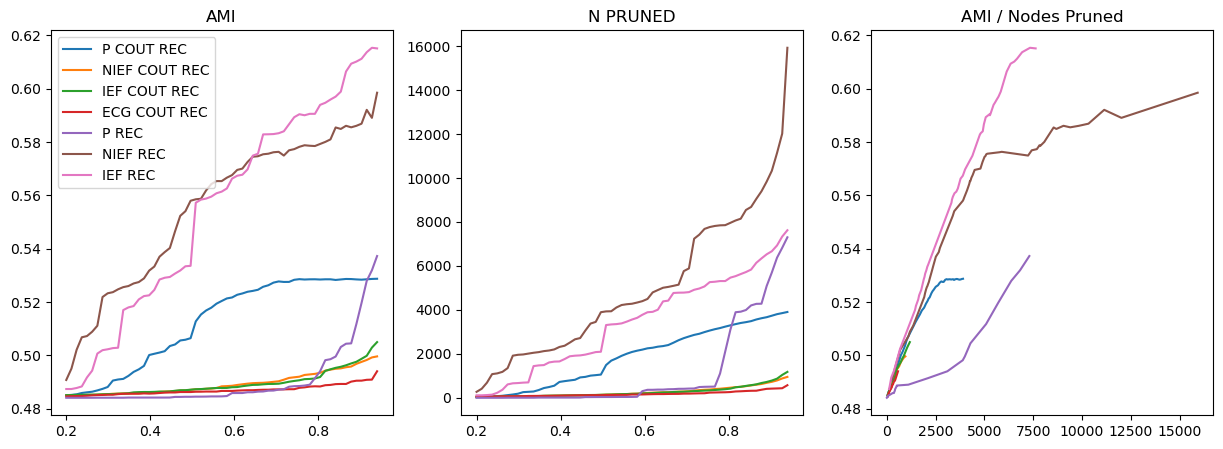

In [ ]:
%%time
g = ig.Graph.Read_GML("real_data/as.gml")
g = g.as_undirected()
vals = np.unique(g.vs["gt"])
id_map = {j:i for i,j in enumerate(vals)}
gt = np.array([id_map[i] for i in g.vs["gt"]])
g = g.get_adjacency_sparse()


p = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.p_to_cluster)
coms = ecg_sn.cluster_edges(g, p)
ecg = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.ecg_to_cluster)
ecg_coms = ecg_sn.cluster_edges(g, ecg)


ief = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.ief_to_cluster)
nief = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.nief_to_cluster)
p = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.p_to_cluster)
ecg = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.ecg_to_cluster)


cuts = np.linspace(0.2, 0.94, 61)  # TODO some error cutting at .95?
pcout_pruned_rec = []
niefcout_pruned_rec = []
iefcout_pruned_rec = []
ecgcout_pruned_rec = []

p_pruned_rec = []
nief_pruned_rec = []
ief_pruned_rec = []

for c in tqdm(cuts):
    iefcout_pruned_rec.append(ecg_sn.prune(g, coms, c, score="cout", edge_weights=ief))
    niefcout_pruned_rec.append(ecg_sn.prune(g, coms, c, score="cout", edge_weights=nief))
    pcout_pruned_rec.append(ecg_sn.prune(g, coms, c, score="cout", edge_weights=p))
    ecgcout_pruned_rec.append(ecg_sn.prune(g, coms, c, score="cout", edge_weights=ecg))

    ief_pruned_rec.append(ecg_sn.prune(g, coms, c, score="ief", max_per_round=100))
    nief_pruned_rec.append(ecg_sn.prune(g, coms, c, score="nief", max_per_round=100))
    p_pruned_rec.append(ecg_sn.prune(g, coms, c, score="p", max_per_round=100))

# plotting
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
options = [
    [pcout_pruned_rec, "P COUT REC"],
    [niefcout_pruned_rec, "NIEF COUT REC"],
    [iefcout_pruned_rec, "IEF COUT REC"],
    [ecgcout_pruned_rec, "ECG COUT REC"],
    [p_pruned_rec, "P REC"],
    [nief_pruned_rec, "NIEF REC"],
    [ief_pruned_rec, "IEF REC"],
]
for pruned, name in options:
    axs[0].plot(cuts, [AMI(gt[~p], coms[~p]) for p in pruned], label=name)
    axs[1].plot(cuts, [np.sum(p) for p in pruned], label=name)
    axs[2].plot([np.sum(p) for p in pruned], [AMI(gt[~p], coms[~p]) for p in pruned], label=name)
    
axs[0].set_title("AMI")
axs[1].set_title("N PRUNED")
axs[2].set_title("AMI / Nodes Pruned")
axs[0].legend()

100%|██████████| 61/61 [00:16<00:00,  3.74it/s]


CPU times: user 40.6 s, sys: 20 ms, total: 40.6 s
Wall time: 40.6 s


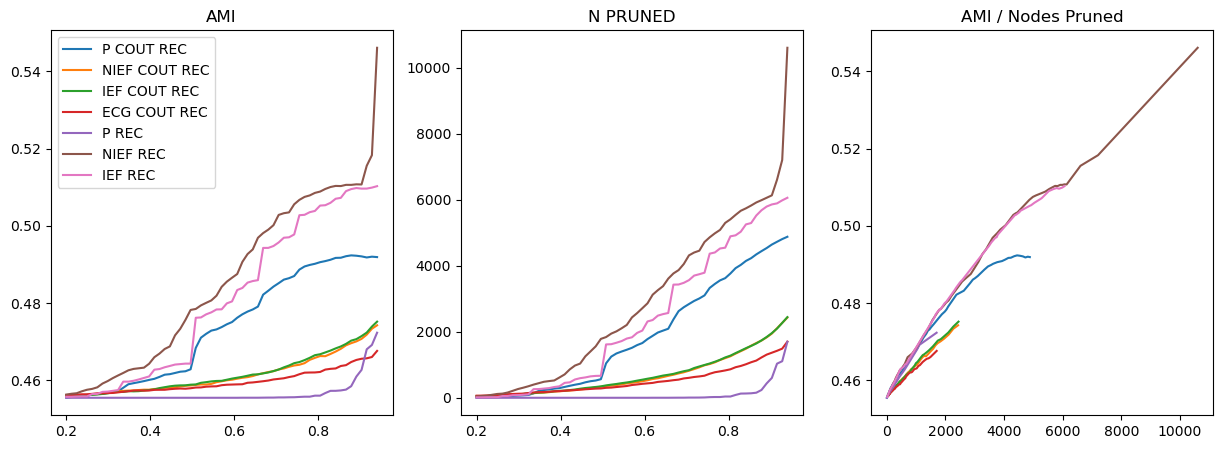

In [18]:
%%time
g = ig.Graph.Read_GML("real_data/cora_full.gml")
g = g.as_undirected()
vals = np.unique(g.vs["gt"])
id_map = {j:i for i,j in enumerate(vals)}
gt = np.array([id_map[i] for i in g.vs["gt"]])
g = g.get_adjacency_sparse()


p = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.p_to_cluster)
coms = ecg_sn.cluster_edges(g, p)
ecg = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.ecg_to_cluster)
ecg_coms = ecg_sn.cluster_edges(g, ecg)


ief = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.ief_to_cluster)
nief = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.nief_to_cluster)
p = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.p_to_cluster)
ecg = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.ecg_to_cluster)


cuts = np.linspace(0.2, 0.94, 61)
pcout_pruned_rec = []
niefcout_pruned_rec = []
iefcout_pruned_rec = []
ecgcout_pruned_rec = []

p_pruned_rec = []
nief_pruned_rec = []
ief_pruned_rec = []

for c in tqdm(cuts):
    iefcout_pruned_rec.append(ecg_sn.prune(g, coms, c, score="cout", edge_weights=ief))
    niefcout_pruned_rec.append(ecg_sn.prune(g, coms, c, score="cout", edge_weights=nief))
    pcout_pruned_rec.append(ecg_sn.prune(g, coms, c, score="cout", edge_weights=p))
    ecgcout_pruned_rec.append(ecg_sn.prune(g, coms, c, score="cout", edge_weights=ecg))

    ief_pruned_rec.append(ecg_sn.prune(g, coms, c, score="ief", max_per_round=100))
    nief_pruned_rec.append(ecg_sn.prune(g, coms, c, score="nief", max_per_round=100))
    p_pruned_rec.append(ecg_sn.prune(g, coms, c, score="p", max_per_round=100))

# plotting
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
options = [
    [pcout_pruned_rec, "P COUT REC"],
    [niefcout_pruned_rec, "NIEF COUT REC"],
    [iefcout_pruned_rec, "IEF COUT REC"],
    [ecgcout_pruned_rec, "ECG COUT REC"],
    [p_pruned_rec, "P REC"],
    [nief_pruned_rec, "NIEF REC"],
    [ief_pruned_rec, "IEF REC"],
]
for pruned, name in options:
    axs[0].plot(cuts, [AMI(gt[~p], coms[~p]) for p in pruned], label=name)
    axs[1].plot(cuts, [np.sum(p) for p in pruned], label=name)
    axs[2].plot([np.sum(p) for p in pruned], [AMI(gt[~p], coms[~p]) for p in pruned], label=name)
    
axs[0].set_title("AMI")
axs[1].set_title("N PRUNED")
axs[2].set_title("AMI / Nodes Pruned")
axs[0].legend()

100%|██████████| 61/61 [00:00<00:00, 109.52it/s]


CPU times: user 2.8 s, sys: 80 ms, total: 2.88 s
Wall time: 2.88 s


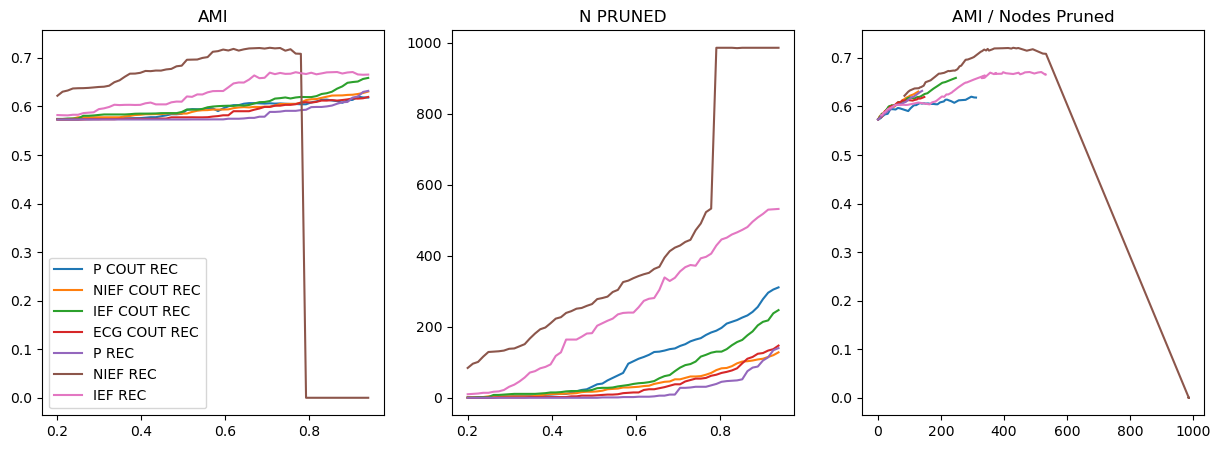

In [20]:
%%time
g = ig.Graph.Read_GML("real_data/eu-core.gml")
g = g.as_undirected()
vals = np.unique(g.vs["gt"])
id_map = {j:i for i,j in enumerate(vals)}
gt = np.array([id_map[i] for i in g.vs["gt"]])
g = g.get_adjacency_sparse()


p = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.p_to_cluster)
coms = ecg_sn.cluster_edges(g, p)
ecg = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.ecg_to_cluster)
ecg_coms = ecg_sn.cluster_edges(g, ecg)


ief = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.ief_to_cluster)
nief = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.nief_to_cluster)
p = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.p_to_cluster)
ecg = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.ecg_to_cluster)


cuts = np.linspace(0.2, 0.94, 61)
pcout_pruned_rec = []
niefcout_pruned_rec = []
iefcout_pruned_rec = []
ecgcout_pruned_rec = []

p_pruned_rec = []
nief_pruned_rec = []
ief_pruned_rec = []

for c in tqdm(cuts):
    iefcout_pruned_rec.append(ecg_sn.prune(g, coms, c, score="cout", edge_weights=ief))
    niefcout_pruned_rec.append(ecg_sn.prune(g, coms, c, score="cout", edge_weights=nief))
    pcout_pruned_rec.append(ecg_sn.prune(g, coms, c, score="cout", edge_weights=p))
    ecgcout_pruned_rec.append(ecg_sn.prune(g, coms, c, score="cout", edge_weights=ecg))

    ief_pruned_rec.append(ecg_sn.prune(g, coms, c, score="ief", max_per_round=100))
    nief_pruned_rec.append(ecg_sn.prune(g, coms, c, score="nief", max_per_round=100))
    p_pruned_rec.append(ecg_sn.prune(g, coms, c, score="p", max_per_round=100))

# plotting
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
options = [
    [pcout_pruned_rec, "P COUT REC"],
    [niefcout_pruned_rec, "NIEF COUT REC"],
    [iefcout_pruned_rec, "IEF COUT REC"],
    [ecgcout_pruned_rec, "ECG COUT REC"],
    [p_pruned_rec, "P REC"],
    [nief_pruned_rec, "NIEF REC"],
    [ief_pruned_rec, "IEF REC"],
]
for pruned, name in options:
    axs[0].plot(cuts, [AMI(gt[~p], coms[~p]) for p in pruned], label=name)
    axs[1].plot(cuts, [np.sum(p) for p in pruned], label=name)
    axs[2].plot([np.sum(p) for p in pruned], [AMI(gt[~p], coms[~p]) for p in pruned], label=name)
    
axs[0].set_title("AMI")
axs[1].set_title("N PRUNED")
axs[2].set_title("AMI / Nodes Pruned")
axs[0].legend()

<timed exec>:1: RuntimeWarning: Unterminated entity or stray & character found, will be returned verbatim. at src/io/gml.c:148
100%|██████████| 61/61 [00:00<00:00, 216.21it/s]


CPU times: user 1.88 s, sys: 0 ns, total: 1.88 s
Wall time: 1.88 s


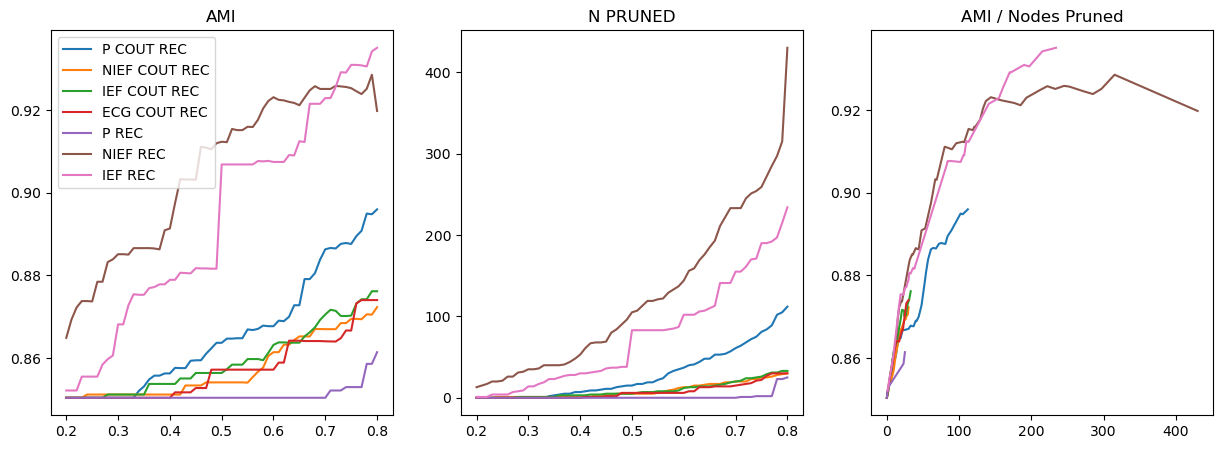

In [22]:
%%time
g = ig.Graph.Read_GML("real_data/eurosis.gml")
g = g.as_undirected()
vals = np.unique(g.vs["gt"])
id_map = {j:i for i,j in enumerate(vals)}
gt = np.array([id_map[i] for i in g.vs["gt"]])
g = g.get_adjacency_sparse()


p = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.p_to_cluster)
coms = ecg_sn.cluster_edges(g, p)
ecg = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.ecg_to_cluster)
ecg_coms = ecg_sn.cluster_edges(g, ecg)


ief = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.ief_to_cluster)
nief = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.nief_to_cluster)
p = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.p_to_cluster)
ecg = ecg_sn.ensemble_cas_edge_weights(g, ecg_sn.ecg_to_cluster)


cuts = np.linspace(0.2, 0.8, 61)
pcout_pruned_rec = []
niefcout_pruned_rec = []
iefcout_pruned_rec = []
ecgcout_pruned_rec = []

p_pruned_rec = []
nief_pruned_rec = []
ief_pruned_rec = []

for c in tqdm(cuts):
    iefcout_pruned_rec.append(ecg_sn.prune(g, coms, c, score="cout", edge_weights=ief))
    niefcout_pruned_rec.append(ecg_sn.prune(g, coms, c, score="cout", edge_weights=nief))
    pcout_pruned_rec.append(ecg_sn.prune(g, coms, c, score="cout", edge_weights=p))
    ecgcout_pruned_rec.append(ecg_sn.prune(g, coms, c, score="cout", edge_weights=ecg))

    ief_pruned_rec.append(ecg_sn.prune(g, coms, c, score="ief", max_per_round=100))
    nief_pruned_rec.append(ecg_sn.prune(g, coms, c, score="nief", max_per_round=100))
    p_pruned_rec.append(ecg_sn.prune(g, coms, c, score="p", max_per_round=100))

# plotting
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
options = [
    [pcout_pruned_rec, "P COUT REC"],
    [niefcout_pruned_rec, "NIEF COUT REC"],
    [iefcout_pruned_rec, "IEF COUT REC"],
    [ecgcout_pruned_rec, "ECG COUT REC"],
    [p_pruned_rec, "P REC"],
    [nief_pruned_rec, "NIEF REC"],
    [ief_pruned_rec, "IEF REC"],
]
for pruned, name in options:
    axs[0].plot(cuts, [AMI(gt[~p], coms[~p]) for p in pruned], label=name)
    axs[1].plot(cuts, [np.sum(p) for p in pruned], label=name)
    axs[2].plot([np.sum(p) for p in pruned], [AMI(gt[~p], coms[~p]) for p in pruned], label=name)
    
axs[0].set_title("AMI")
axs[1].set_title("N PRUNED")
axs[2].set_title("AMI / Nodes Pruned")
axs[0].legend()